# Write to a single zfs filesystem on a NVME-SSD

A server had six Intel P3520 (1.1TB). Each disk was formated with a zfs file system.
A single write wrote the a single file system and the corresponding SSD was traced with _blktrace_ and _btt_ was used to extract data. 

Writer: fio was used to issue the write requests:
```
% fio --dir=/nvme1n1/wktst --name t1 --size=800gi --rw=write \
%     --ioengine=sync --group_reporting=1 --minimal --bs=8mi --numjobs=1
```

Tracing: the block layer requests were recorded using 
```
% blktrace -d /dev/nvme1n1 -o nvme1n1 -w 600
% blkparse -i nvme2n1 -d forbtt.bin --no-text-output
% btt_stats.sh forbtt.bin
```

The tests were performed on 2018-03-16 starting at 14:46 and ending at 15:05 (PDT)

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
resfolder = "/reg/neh/home/wilko/data/ana/drp/t20180316_t4/res"

# FIO write latency

[5210.0, 5472.0, 5603.0, 5865.0, 6717.0, 7045.0, 7438.0, 12910.0, 14352.0, 14745.0, 16318.0, 19005.0, 22413.0, 23724.0, 31064.0, 32899.0, 35389.0]


Text(0,0.5,'latency [ms]')

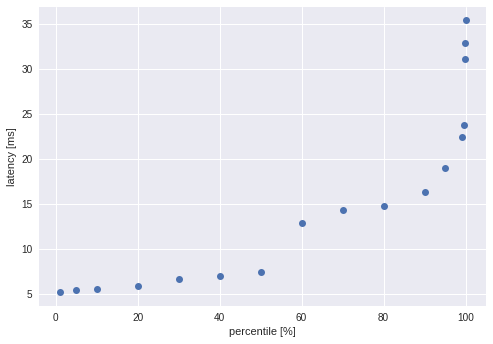

In [13]:
from psdmtst.fioread import read_fio_log

tst = next(read_fio_log("/reg/neh/home/wilko/data/ana/drp/t20180316_t4/fio.log"))
print(tst.write.clat_value)
plt.plot(tst.write.clat_perc, np.array(tst.write.clat_value)/1000.0, 'o')
plt.xlabel("percentile [%]")
plt.ylabel("latency [ms]")

# Queue latencies 

In [14]:
lat_q = pd.read_csv(os.path.join(resfolder, "lat_nvme1n1_q2c.csv"))
lat_d = pd.read_csv(os.path.join(resfolder, "lat_nvme1n1_d2c.csv"))
lat_q.lat *= 1000.
lat_d.lat *= 1000.

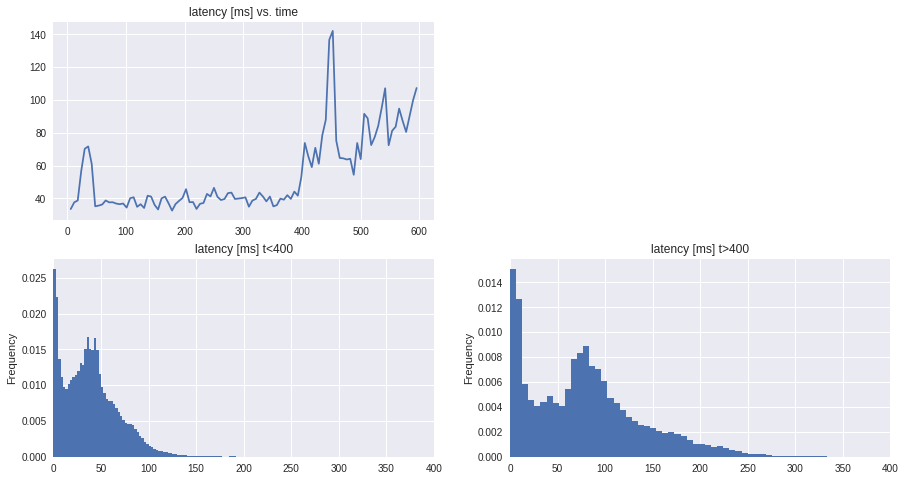

In [15]:
ax = plt.figure(figsize=(15, 8))
cut, bins = pd.cut(lat_d.ts, 100, retbins=True)
grouped = lat_d.groupby(cut)
res = grouped.aggregate(np.mean)
res.set_index(bins[1:], inplace=True)
plt.subplot(2,2,1)
res.lat.plot(title="latency [ms] vs. time")

xr = (0, 400)
plt.subplot(2,2,3)
lat_q.loc[lat_q.ts < 400].lat.plot(kind='hist',bins=100, xlim=xr, title="latency [ms] t<400", density=True)

plt.subplot(2,2,4)
lat_q.loc[lat_q.ts >= 400].lat.plot(kind='hist',bins=100, xlim=xr, title="latency [ms] t>400", density=True)

# Seeks

In [16]:
seeks = pd.read_csv(os.path.join(resfolder, "seeks_nvme1n1_d2d_c.csv"))
seeks.head()

,ts,seek,rw
0,0.000006,8192,r
1,0.145713,505204176,w
2,0.145713,2008,w
3,0.145716,0,w
4,0.145717,-2048,w


1229 5043095


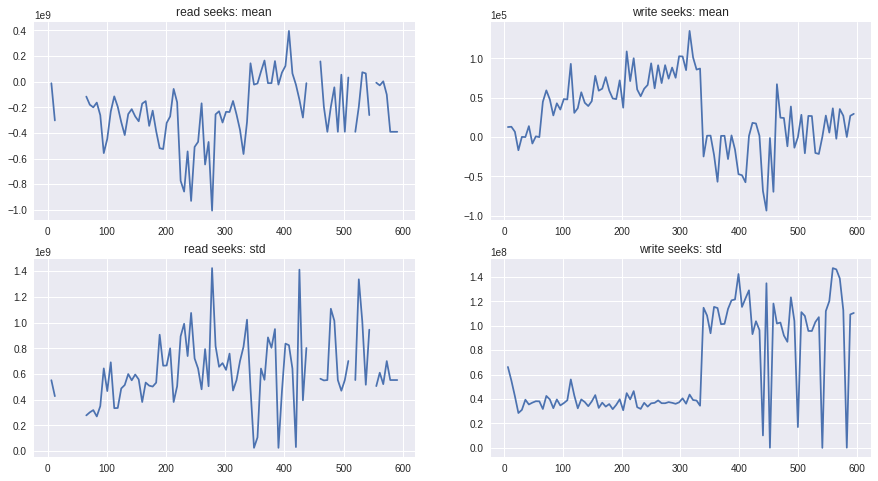

In [17]:
ax = plt.figure(figsize=(15, 8))
s_read = seeks.loc[seeks.rw == 'r']
s_write = seeks.loc[seeks.rw == 'w']
print(len(s_read), len(s_write))

for n, func in enumerate((np.mean, np.std)):
    if len(s_read) > 0:
        scut, sbins = pd.cut(s_read.ts, 100, retbins=True)
        sres = s_read.groupby(scut).aggregate(func)
        sres.set_index(sbins[1:], inplace=True)
        plt.subplot(2,2,n*2+1)
        sres.seek.plot(title="read seeks: {}".format(func.__name__))
    if len(s_write):
        scut, sbins = pd.cut(s_write.ts, 100, retbins=True)
        sres = s_write.groupby(scut).aggregate(func)
        sres.set_index(sbins[1:], inplace=True)
        plt.subplot(2,2,n*2+2)
        sres.seek.plot(title="write seeks: {}".format(func.__name__))

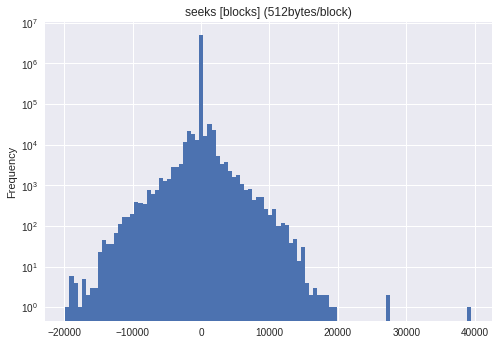

In [18]:
seeks.loc[(seeks.seek > -50000) & (seeks.seek < 50000)].seek.plot.hist(bins=100, logy=True, title="seeks [blocks] (512bytes/block)")